1. Data Loading and Initial Inspection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

# Set display options for better viewing of dataframes
pd.set_option('display.max_columns', None)

# --- Unzip the File ---
zip_path = 'house-prices-advanced-regression-techniques.zip'
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('house-prices-advanced-regression-techniques')
    print("File unzipped successfully!")
except FileNotFoundError:
    print(f"Error: '{zip_path}' not found. Please ensure you have uploaded the zip file correctly.")
    exit()

# --- Load the Data ---
file_path = 'house-prices-advanced-regression-techniques/train.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Please ensure the file is in the correct location.")
    exit()

# --- Initial Inspection ---
print("\n--- 1. First 5 rows of the dataset ---")
print(df.head())

print("\n--- 2. Dataset Information: Columns, Non-Null Counts, Data Types ---")
df.info()

print("\n--- 3. Basic Statistical Summary of Numerical Columns ---")
print(df.describe())

print("\n--- 4. Check for Missing Values (Top 20 Missing) ---")
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_percent = (missing_data / len(df)) * 100
missing_table = pd.DataFrame({'Missing Count': missing_data, 'Missing %': missing_percent})
print(missing_table.head(20))

File unzipped successfully!
Dataset loaded successfully!

--- 1. First 5 rows of the dataset ---
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyl

2. Handling Missing Values

--- Check for Missing Values After Initial Cleaning ---
Series([], dtype: int64)


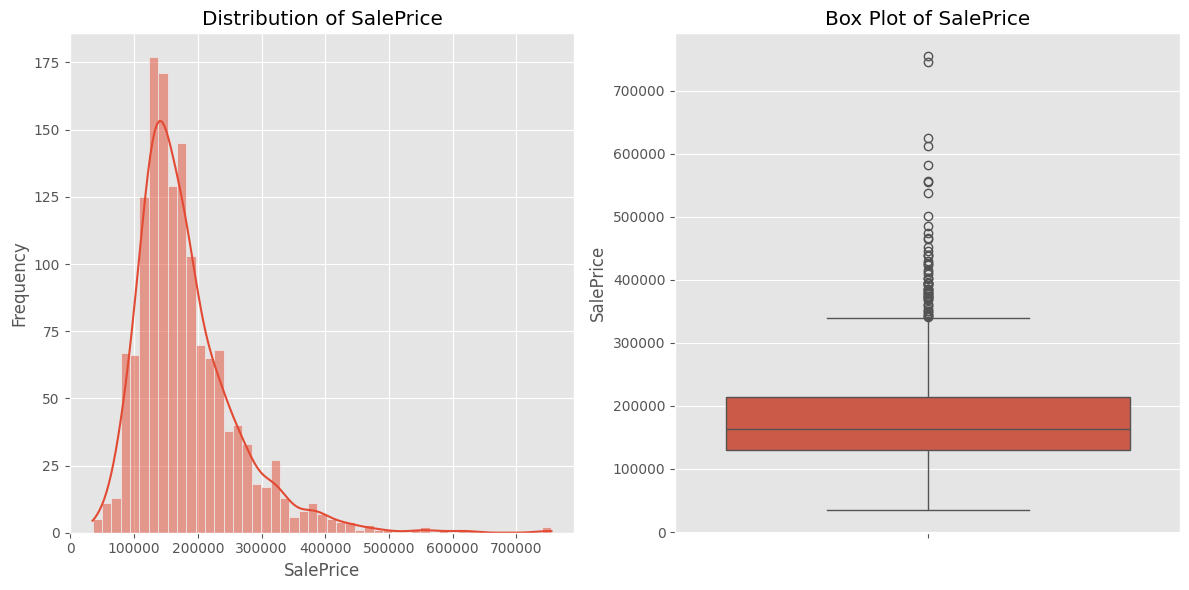

In [2]:
# Create a copy of the dataframe to avoid altering the original
df_cleaned = df.copy()

# Categorical features with missing values that should be filled with 'None'
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'GarageType',
            'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
            'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'Electrical', 'MSZoning', 'Utilities',
            'Functional', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual'):
    df_cleaned[col] = df_cleaned[col].fillna('None')

# Numerical features with missing values that should be filled with 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
            'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    df_cleaned[col] = df_cleaned[col].fillna(0)

# LotFrontage is a special case as it is a numerical value that depends on neighborhood
df_cleaned['LotFrontage'] = df_cleaned.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# Drop the 'Id' column as it is not needed for modeling
df_cleaned = df_cleaned.drop("Id", axis=1)

# Check the new number of missing values
print("--- Check for Missing Values After Initial Cleaning ---")
missing_after = df_cleaned.isnull().sum()
missing_after = missing_after[missing_after > 0]
print(missing_after)

# --- Visualization of the Target Variable (SalePrice) ---
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_cleaned['SalePrice'])
plt.title('Box Plot of SalePrice')
plt.ylabel('SalePrice')

plt.tight_layout()
plt.show()

# After you run the code, please share the new output for the missing values and the two visualizations.

3. Handling Skewness

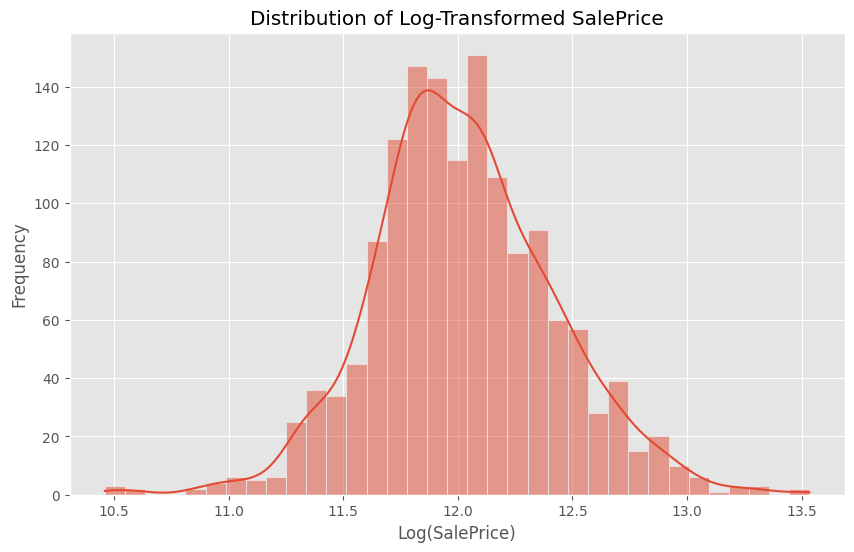

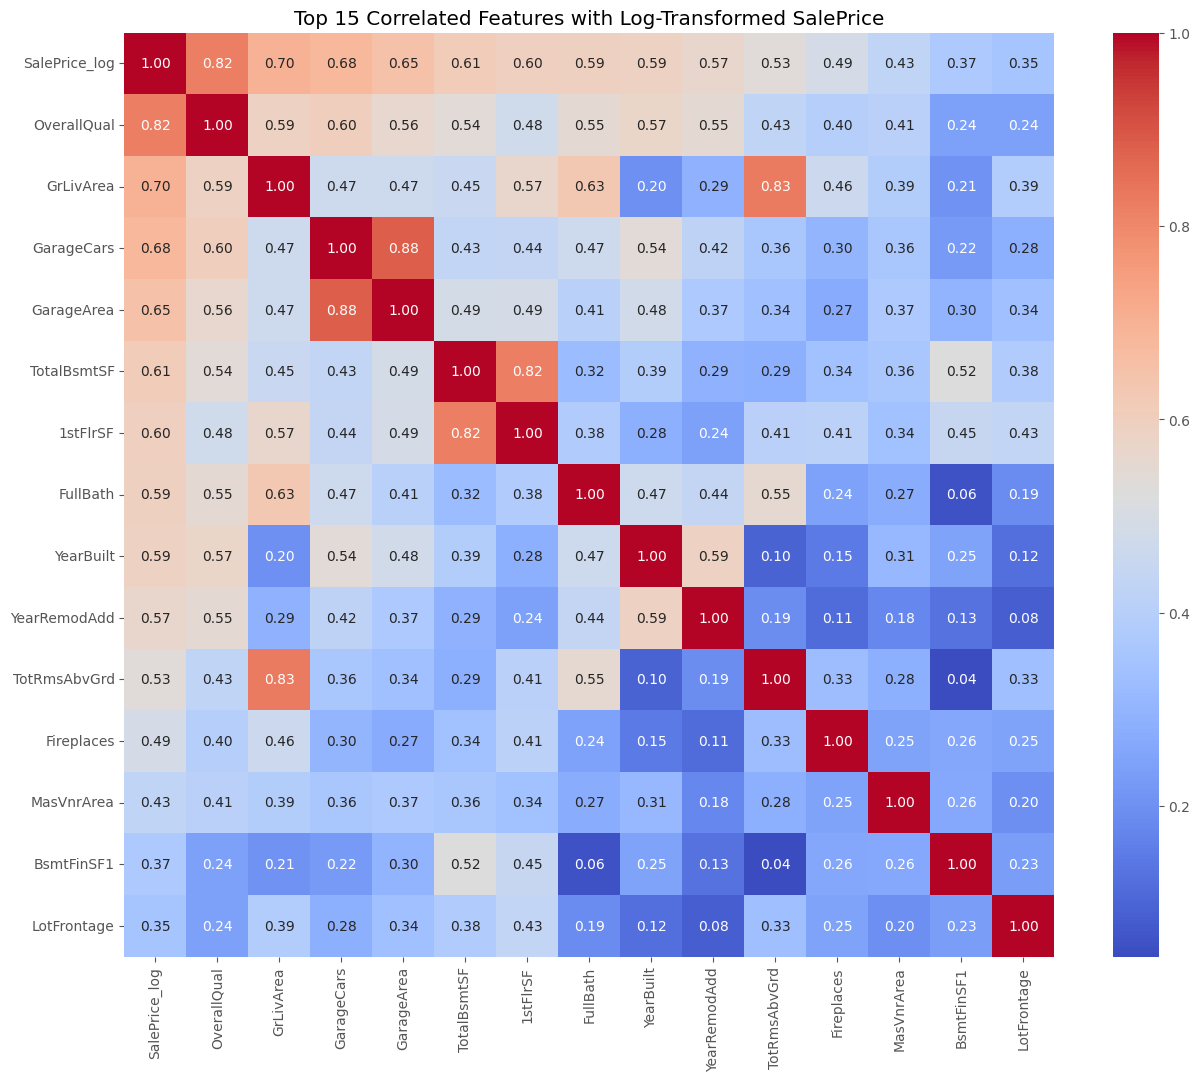

In [3]:
# Create a new column with the log-transformed SalePrice
df_cleaned['SalePrice_log'] = np.log(df_cleaned['SalePrice'])

# Drop the original SalePrice column
df_cleaned = df_cleaned.drop('SalePrice', axis=1)

# Visualize the new log-transformed target variable
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['SalePrice_log'], kde=True)
plt.title('Distribution of Log-Transformed SalePrice')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')
plt.show()

# Now, we will look at the correlation with our numerical features
# Get the top 15 correlated features with the new SalePrice_log
corrmat = df_cleaned.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(15, 'SalePrice_log')['SalePrice_log'].index

# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(df_cleaned[top_corr_features].corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Top 15 Correlated Features with Log-Transformed SalePrice')
plt.show()

4. Deeper Feature Analysis

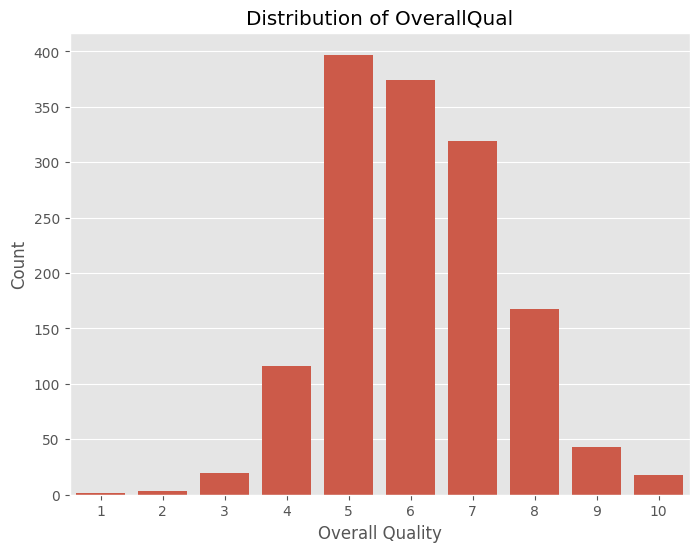

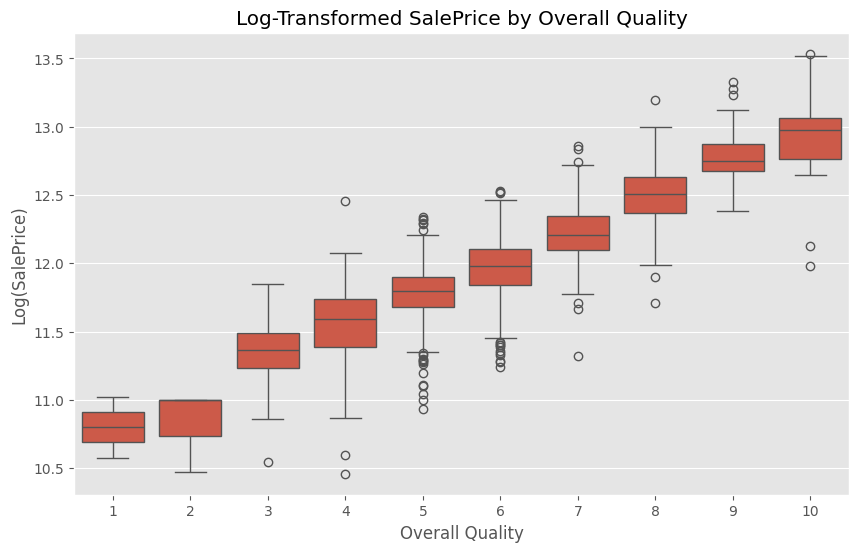

In [4]:
# --- 1. Univariate Analysis of OverallQual ---
plt.figure(figsize=(8, 6))
sns.countplot(x='OverallQual', data=df_cleaned)
plt.title('Distribution of OverallQual')
plt.xlabel('Overall Quality')
plt.ylabel('Count')
plt.show()

# --- 2. Bivariate Analysis: OverallQual vs. SalePrice_log ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice_log', data=df_cleaned)
plt.title('Log-Transformed SalePrice by Overall Quality')
plt.xlabel('Overall Quality')
plt.ylabel('Log(SalePrice)')
plt.show()

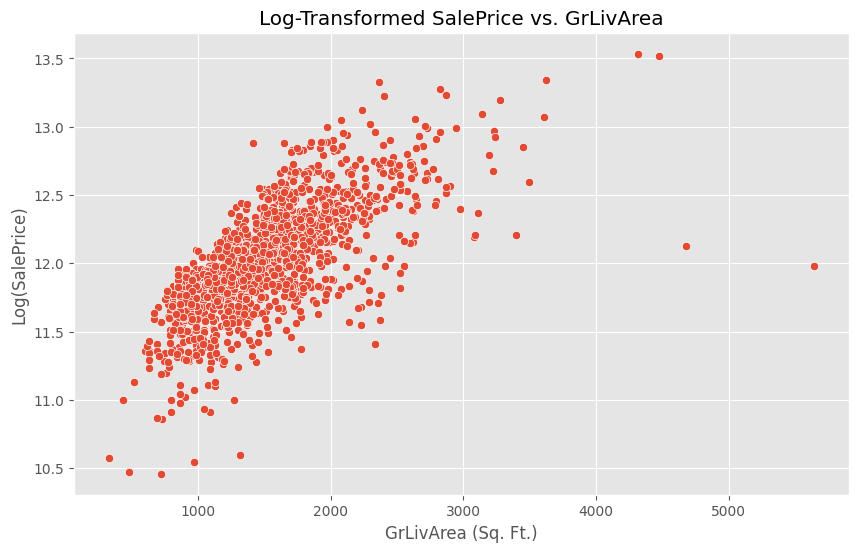

In [5]:
# --- Bivariate Analysis: GrLivArea vs. SalePrice_log ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice_log', data=df_cleaned)
plt.title('Log-Transformed SalePrice vs. GrLivArea')
plt.xlabel('GrLivArea (Sq. Ft.)')
plt.ylabel('Log(SalePrice)')
plt.show()

6. Outlier Removal

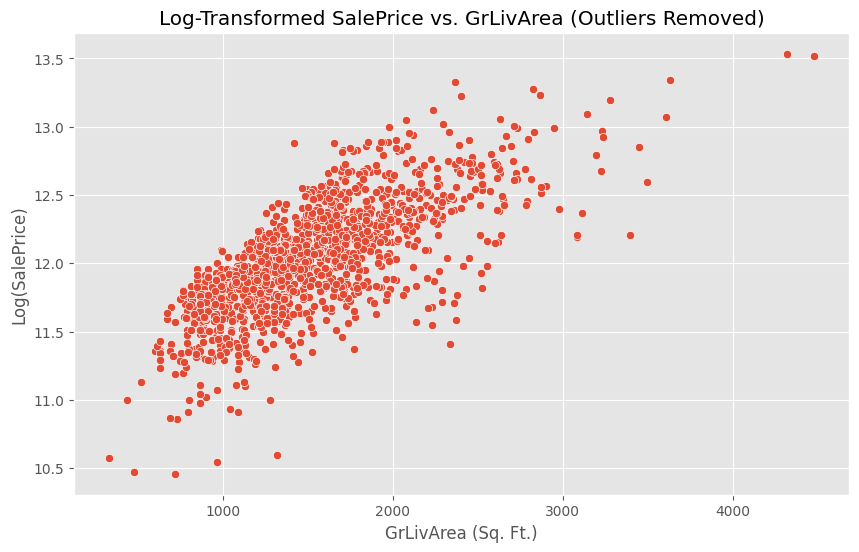

In [6]:
# Identify the outliers by their GrLivArea
# We can see from the scatter plot that these are houses with GrLivArea > 4000
df_cleaned = df_cleaned.drop(df_cleaned[(df_cleaned['GrLivArea']>4000) & (df_cleaned['SalePrice_log']<12.5)].index)

# Now, visualize the cleaned data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice_log', data=df_cleaned)
plt.title('Log-Transformed SalePrice vs. GrLivArea (Outliers Removed)')
plt.xlabel('GrLivArea (Sq. Ft.)')
plt.ylabel('Log(SalePrice)')
plt.show()

7. Analyzing Neighborhood

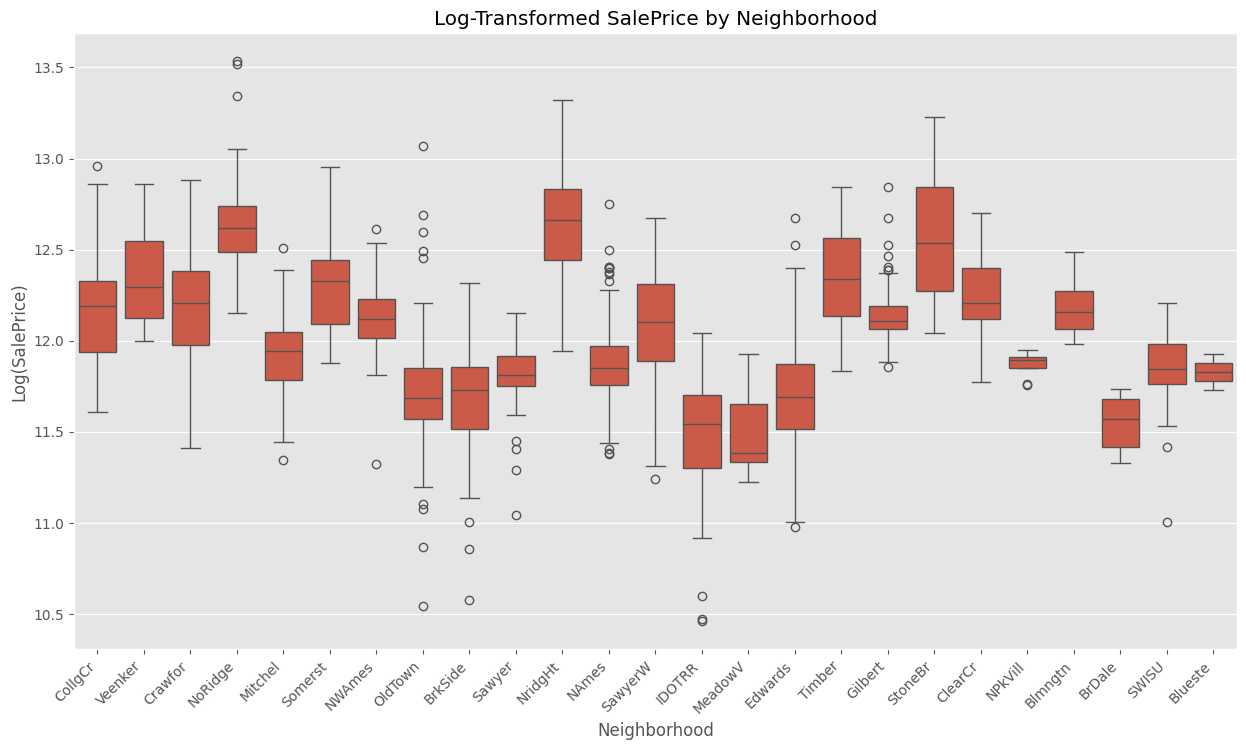

In [7]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='Neighborhood', y='SalePrice_log', data=df_cleaned)
plt.title('Log-Transformed SalePrice by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Log(SalePrice)')
plt.xticks(rotation=45, ha='right')
plt.show()

8. Preparing Data for Modeling (Feature Engineering)

In [8]:
# Create a new dataframe with the SalePrice_log target variable
y = df_cleaned['SalePrice_log']

# Create a new dataframe with the remaining features for engineering
X = df_cleaned.drop('SalePrice_log', axis=1)

# Get the list of all categorical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Apply One-Hot Encoding to the categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Print the shape and first 5 rows of the new, encoded dataframe
print("Shape of the encoded dataframe:", X_encoded.shape)
print("\nFirst 5 rows of the encoded dataframe:")
print(X_encoded.head())

Shape of the encoded dataframe: (1458, 259)

First 5 rows of the encoded dataframe:
   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          2003       196.0         706           0        150          856   
1          1976         0.0         978           0        284         1262   
2          2002       162.0         486           0        434          920   
3          1970         0.0         216           0        540          756   
4          2000       350.0         655           0        490  

9. Model Building and Evaluation

Model has been trained and evaluated.
Root Mean Squared Error (RMSE): 0.1372


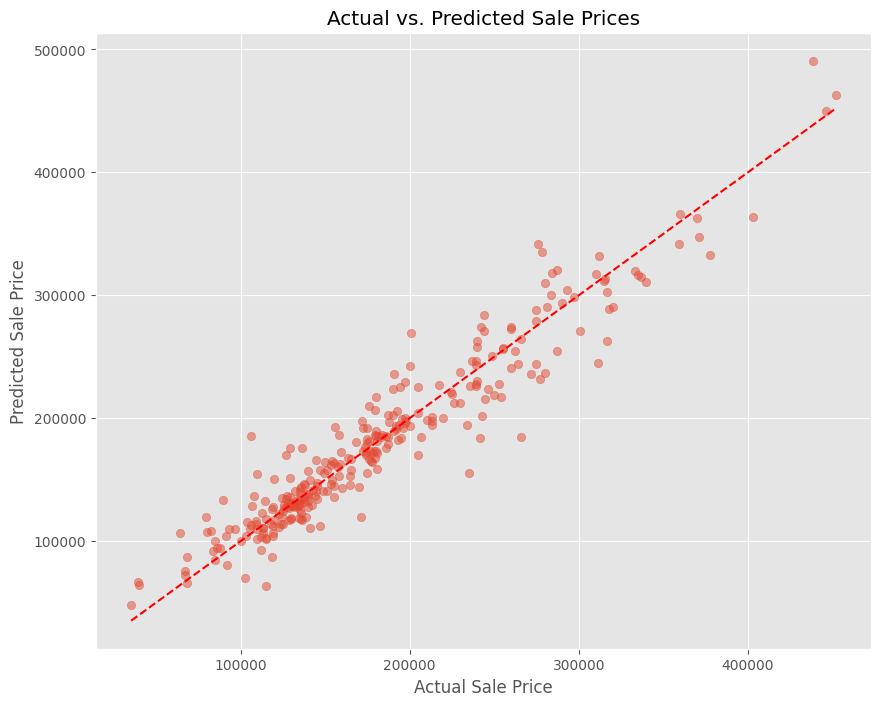

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create a Linear Regression model and train it
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model has been trained and evaluated.")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Convert the predictions back to the original SalePrice scale
y_pred_original_scale = np.exp(y_pred)
y_test_original_scale = np.exp(y_test)

# Plot the actual vs. predicted prices
plt.figure(figsize=(10, 8))
plt.scatter(y_test_original_scale, y_pred_original_scale, alpha=0.5)
plt.plot([y_test_original_scale.min(), y_test_original_scale.max()], [y_test_original_scale.min(), y_test_original_scale.max()], 'r--')
plt.title('Actual vs. Predicted Sale Prices')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

10. Implementing an Advanced Model (XGBoost)

In [10]:
from xgboost import XGBRegressor

# Create an XGBoost Regressor model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate the model
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))

print("XGBoost Model has been trained and evaluated.")
print(f"XGBoost Root Mean Squared Error (RMSE): {xgb_rmse:.4f}")

XGBoost Model has been trained and evaluated.
XGBoost Root Mean Squared Error (RMSE): 0.1411


11. Applying More Advanced Models

In [11]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

# Create and train the Lasso Regression model
lasso_model = Lasso(alpha=0.0005, random_state=42)
lasso_model.fit(X_train, y_train)

# Make predictions and evaluate Lasso's performance
lasso_y_pred = lasso_model.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_y_pred))

# Create and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate Random Forest's performance
rf_y_pred = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))

# Print the results
print("Lasso Root Mean Squared Error (RMSE):", round(lasso_rmse, 4))
print("Random Forest Root Mean Squared Error (RMSE):", round(rf_rmse, 4))

Lasso Root Mean Squared Error (RMSE): 0.1245
Random Forest Root Mean Squared Error (RMSE): 0.1468


12. Hypothesis Testing & Additional Metrics

In [12]:
from scipy import stats
from sklearn.metrics import r2_score, mean_absolute_error

# Hypothesis Test: T-test for `OverallQual`
# We'll compare the prices of houses with a high quality vs. low quality
low_qual_prices = df_cleaned[df_cleaned['OverallQual'] < 5]['SalePrice_log']
high_qual_prices = df_cleaned[df_cleaned['OverallQual'] > 7]['SalePrice_log']

t_stat, p_value = stats.ttest_ind(high_qual_prices, low_qual_prices, equal_var=False)

print("--- T-Test for OverallQual vs. SalePrice ---")
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("\nConclusion: The difference is statistically significant. High-quality houses have a significantly higher sale price.")
else:
    print("\nConclusion: The difference is NOT statistically significant.")

# Calculate R-squared and MAE for all models for comparison
lasso_r2 = r2_score(y_test, lasso_y_pred)
lasso_mae = mean_absolute_error(y_test, lasso_y_pred)

xgb_r2 = r2_score(y_test, xgb_y_pred)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)

lr_r2 = r2_score(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)

rf_r2 = r2_score(y_test, rf_y_pred)
rf_mae = mean_absolute_error(y_test, rf_y_pred)

print("\n--- Model Evaluation Summary ---")
print(f"Lasso R-squared: {lasso_r2:.4f}, MAE: {lasso_mae:.4f}")
print(f"XGBoost R-squared: {xgb_r2:.4f}, MAE: {xgb_mae:.4f}")
print(f"Linear Regression R-squared: {lr_r2:.4f}, MAE: {lr_mae:.4f}")
print(f"Random Forest R-squared: {rf_r2:.4f}, MAE: {rf_mae:.4f}")

--- T-Test for OverallQual vs. SalePrice ---
T-statistic: 33.21
P-value: 0.0000

Conclusion: The difference is statistically significant. High-quality houses have a significantly higher sale price.

--- Model Evaluation Summary ---
Lasso R-squared: 0.9081, MAE: 0.0862
XGBoost R-squared: 0.8819, MAE: 0.0932
Linear Regression R-squared: 0.8883, MAE: 0.0935
Random Forest R-squared: 0.8722, MAE: 0.0978


In [15]:
!pip freeze > requirements.txt